# Run

In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
import json
import os
import pandas as pd
import torch

import itertools
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt 
import matplotlib as mpl

import numpy as np
from utils.Visualization import pareto_points
from utils.utils import create_folder, activation_patterns, save_circuit, save_circuit, load_circuit, save_dict, save_img, store_df, load_df
from utils.config import set_PATH
from utils.model_loader import load_tokenizer, load_hooked_transformer,load_transformer, get_gpt2_adapt_to_llama
from utils.dataset_loader import predict_target_token
from utils.PatchingMetric import ave_logit_diff
from dataset.loader import load_dataset
from utils.eval_circuit import evaluate_circiut
from circuits_PP import get_manual_PP_circuit, choose_circuit, get_result_path_PP, get_circuit_name
from circuits_APP import choose_APP_circuit, get_result_path_APP
from circuits_FLAP import choose_contrastive_FLAP_circuit, choose_vanilla_FLAP_circuit, choose_hybrid_FLAP_circuit, get_result_path_FLAP
from utils.eval_circuit import TPR, print_statics, circuit_size, batch_evaluate_circiut, merge_circuits
import gc

from circuits_contr_APP import choose_contr_APP_circuit
from utils.eval_circuit import performance_achieved, circuit_size, get_intersection_num, precision, TPR, get_union_num, merge_circuits
from circuits_PP import choose_circuit
from circuits_FLAP import choose_contrastive_FLAP_circuit, choose_vanilla_FLAP_circuit, choose_hybrid_FLAP_circuit
from circuits_APP import choose_APP_circuit



# Args

In [55]:
all_tasks=["ioi", "GreaterThan", "GenderedPronouns", "induction", "Docstring"]
#all_tasks=["GreaterThan", "GenderedPronouns", "induction", "Docstring", "ioi"]
#all_tasks=["Docstring"]
#all_tasks =  ["ioi"]
# ------------- model -------------
#model_name="Qwen/Qwen2.5-0.5B"
#model_name="Qwen/Qwen2.5-7B"
#model_name="gpt2-large"
model_name="gpt2"

    
# --------------- task -----------------#

#task="GenderedPronouns"
#task="induction"
#task="GreaterThan"
task="ioi"
#task="Docstring"

save_image=True
save_txt=True

N=200
seed=193485603
batch_size=25
epochs = int(N /batch_size)

out_path="/mnt/lustre/work/eickhoff/esx670/res_final"
cache_dir="/mnt/lustre/work/eickhoff/esx670/llm_weights"
set_PATH(out_path)
device="cuda"

if model_name=="gpt2":
    total_model_size = 144
elif model_name=="gpt2-large":
    total_model_size=720
elif model_name=="Qwen/Qwen2.5-0.5B":
    total_model_size=336
elif model_name == "Qwen/Qwen2.5-7B":
    total_model_size=784

# Path Patching

In [ ]:
tokenizer = load_tokenizer(model_name)
model_hooked = load_hooked_transformer(model_name, device=device, cache_dir=cache_dir)

min_activations = [0.01, 0.001, 0.02, 0.002]
scales = [1, 1.5, 2, 2.5]

# directory to Path Patching
PP_df_results = pd.DataFrame(columns=["task", "min_activations", "scale", "performance", "size"])

for task in all_tasks:
    df_results_task = pd.DataFrame(columns=["task", "min_activations", "scale", "performance", "size"])
    directory = f"{out_path}/{model_name}/{task}/path/automatic/logits_diff/sqrt"  
     
    eval_dataset = load_dataset(
        prepend_bos=False,
        task=task, 
        patching_method="path",
        tokenizer=tokenizer, 
        N=N, 
        device=device,
        model_name=model_name,
        seed=seed
    )

    # ----- Average Logit Difference of the unpatched Model -----
    with torch.no_grad():
        logits_gt = model_hooked(eval_dataset.clean_tokens)
        
    ave_logit_gt = ave_logit_diff(
        logits=logits_gt, 
        correct_answers=eval_dataset.correct_answers, 
        wrong_answers=eval_dataset.wrong_answers,
        target_idx=eval_dataset.target_idx.to(device), 
        task=task,
        model_name=model_name
        )
    
    for ma in min_activations:
        for s in scales:
            
            circuit_path = f"{directory}/min_threshold-{ma}/k_2-scale_{s}/"        
            CIRCUIT = load_circuit(circuit_path, "circuit.txt")
            
            
            size = circuit_size(CIRCUIT)            
            ave_logit, performance = batch_evaluate_circiut(
                model = model_hooked, 
                CIRCUIT=CIRCUIT,
                dataset=eval_dataset,
                ave_logit_gt=ave_logit_gt,
                task=task,
                model_name=model_name, 
                epochs = epochs, 
                batch_size = batch_size 
            )    
                
            new_row = pd.DataFrame({
                "task": [task],
                "min_activations": [ma],
                "scale": [s],
                "performance": [performance], 
                "size": [size]
            }) 
            
            df_results_task = pd.concat([df_results_task, new_row],  ignore_index=True)

    if save_txt:
        store_df(df_results_task, out_path=directory, name="results_pp.json")         
          
    if not save_img:
        save_img_path=None
    else:
        save_img_path=directory
    
    PP_df_results = pd.concat([PP_df_results, df_results_task], ignore_index=True)
PP_df_results

load gpt2 tokenizer


NameError: name 'device' is not defined

## Pareto Frontier for PP

In [ ]:
PP_df_results[PP_df_results['task']=="ioi"]

,task,min_activations,scale,performance,size
0,ioi,0.010,1,57.930368,175
1,ioi,0.010,1.5,39.216634,91
2,ioi,0.010,2,18.109284,69
3,ioi,0.010,2.5,23.803191,62
4,ioi,0.001,1,97.920696,641
5,ioi,0.001,1.5,98.355899,623
6,ioi,0.001,2,91.054159,582
7,ioi,0.001,2.5,86.025145,422
8,ioi,0.020,1,45.164410,97
9,ioi,0.020,1.5,33.945841,70


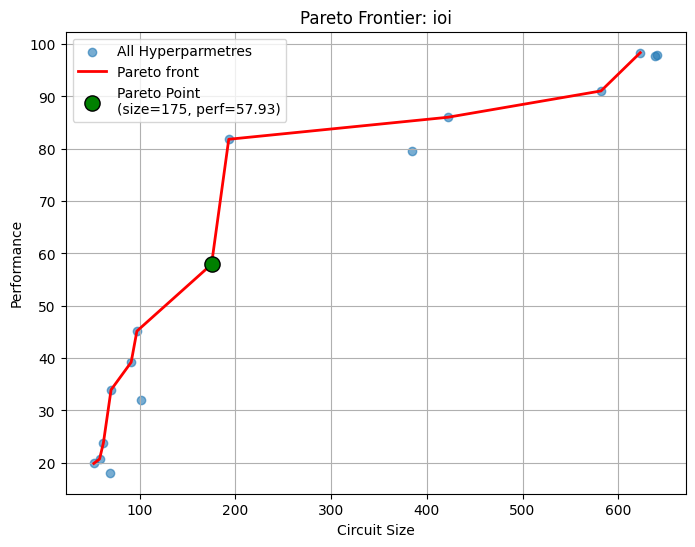

27


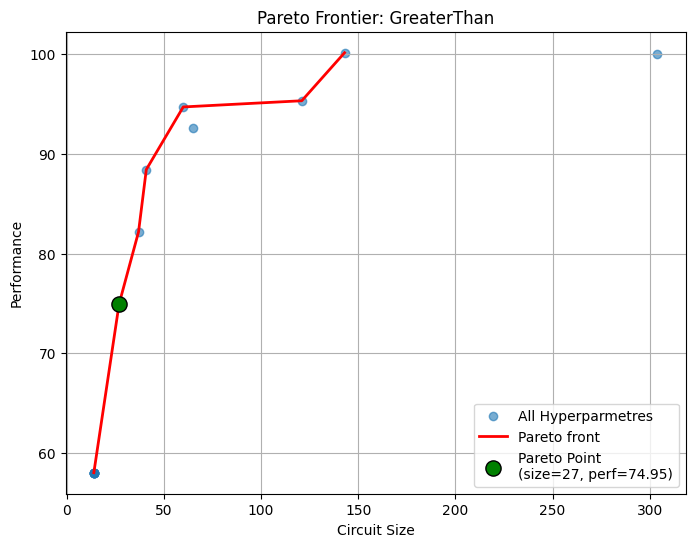

101


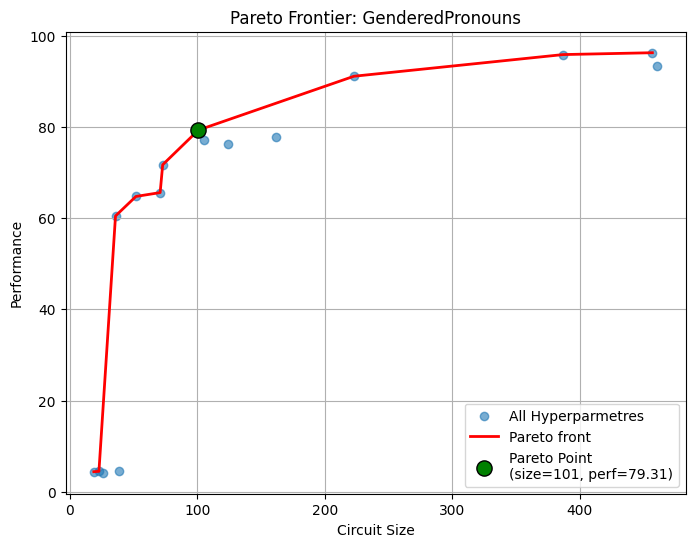

67


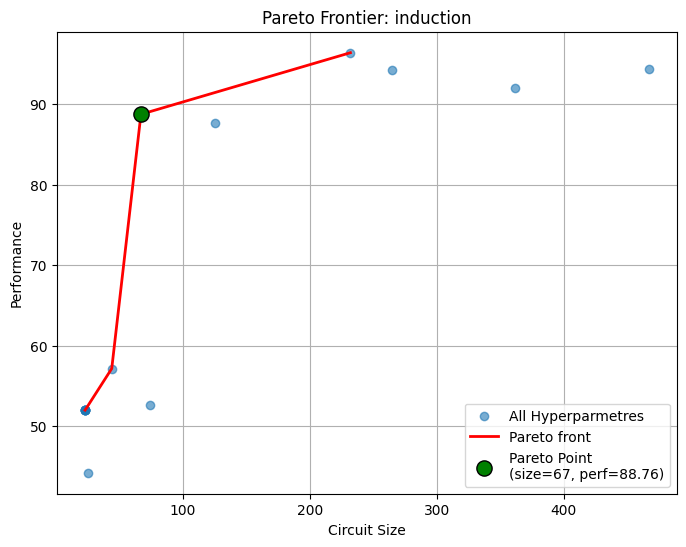

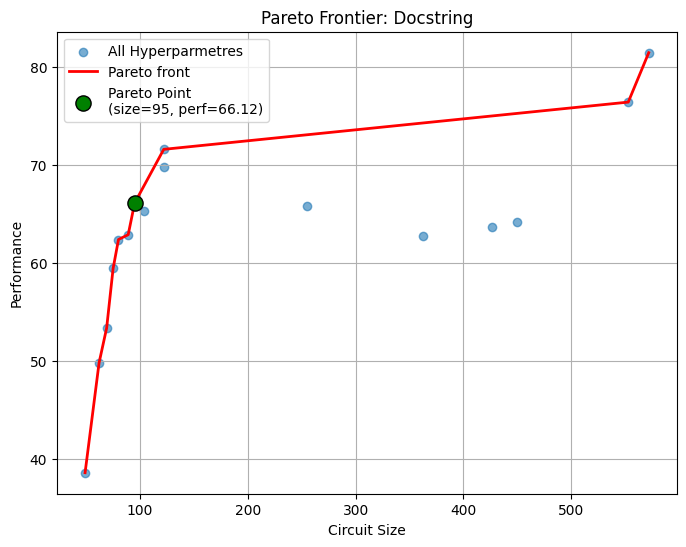

In [ ]:

for task in all_tasks:
    #df_task = PP_df_results[PP_df_results["task"]== task] 
    df_task = PP_df_results[PP_df_results["task"]== task] 


    def pareto_frontier(df, x_col, y_col, maximize_y=True, minimize_x=True):
        df_sorted = df.sort_values(by=[x_col], ascending=minimize_x)
        pareto = []
        best_y = -float("inf") if maximize_y else float("inf")
        for _, row in df_sorted.iterrows():
            y = row[y_col]
            if maximize_y:
                if y > best_y:
                    pareto.append(row)
                    best_y = y
            else:
                if y < best_y:
                    pareto.append(row)
                    best_y = y
        return pd.DataFrame(pareto)

    pareto = pareto_frontier(df_task, "size", "performance")

    try:
        best_point = df_task[df_task["performance"] >= 73].sort_values(by="size").iloc[0]
        if best_point["size"] > total_model_size/4:
            raise Exception
        print(best_point["size"])
    except:
        best_point = df_task[df_task["performance"] >= df_task["performance"].mean()].sort_values(by="size").iloc[0]


    plt.figure(figsize=(8,6))
    plt.scatter(df_task["size"], df_task["performance"], label="All Hyperparmetres", alpha=0.6)
    plt.plot(pareto["size"], pareto["performance"], color="red", linewidth=2, label="Pareto front")
    plt.scatter(best_point["size"], best_point["performance"],
                color="green", s=120, marker="o", edgecolors="black", zorder=5,
                label=f"Pareto Point\n(size={best_point['size']}, perf={best_point['performance']:.2f})")

    plt.xlabel("Circuit Size")
    plt.ylabel("Performance")
    plt.title("Pareto Frontier: " + task)
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
PP_df_results[PP_df_results["task"]=="Docstring"]

,task,min_activations,scale,performance,size
64,Docstring,0.010,1,71.600877,122
65,Docstring,0.010,1.5,66.118421,95
66,Docstring,0.010,2,62.390351,80
67,Docstring,0.010,2.5,59.429825,75
68,Docstring,0.001,1,64.144737,450
69,Docstring,0.001,1.5,63.706140,427
70,Docstring,0.001,2,65.844298,255
71,Docstring,0.001,2.5,65.350877,104
72,Docstring,0.020,1,62.883772,89
73,Docstring,0.020,1.5,53.344298,69


# APP

In [56]:
tokenizer = load_tokenizer(model_name)
model_hooked = load_hooked_transformer(model_name, device=device, cache_dir=cache_dir)

min_activations = [0.01, 0.001, 0.02, 0.002]
scales = [1, 1.5, 2, 2.5]

use_contrastive = False

# directory to Path Patching
APP_df_results = pd.DataFrame(columns=["task", "min_activations", "scale", "performance", "TPR", "P", "IoU", "size"])

for task in all_tasks:
    df_results_task = pd.DataFrame(columns=["task", "min_activations", "scale", "performance", "TPR", "P", "IoU", "size"])
    #directory = f"{out_path}/{model_name}/{task}/FLAP_Path_Patching/logits_diff/sqrt/"   # ioi
    if use_contrastive:
        directory = f"{out_path}/{model_name}/{task}/contr_APP"   # ioi
    else:
        directory = f"{out_path}/{model_name}/{task}/APP"   # ioi

    PP_CIRCUIT = choose_circuit(task, model_name)
    
    eval_dataset = load_dataset(
        prepend_bos=False,
        task=task, 
        patching_method="path",
        tokenizer=tokenizer, 
        N=N, 
        device=device,
        model_name=model_name,
        seed=seed
    )

    # ----- Average Logit Difference of the unpatched Model -----
    with torch.no_grad():
        logits_gt = model_hooked(eval_dataset.clean_tokens)
        
    ave_logit_gt = ave_logit_diff(
        logits=logits_gt, 
        correct_answers=eval_dataset.correct_answers, 
        wrong_answers=eval_dataset.wrong_answers,
        target_idx=eval_dataset.target_idx.to(device), 
        task=task,
        model_name=model_name
        )
    
    for ma in min_activations:
        for s in scales:
            
            circuit_path = f"{directory}/min_threshold-{ma}/scale-{s}/"        
            APP_CIRCUIT = load_circuit(circuit_path, "circuit.txt")
        
            size = circuit_size(APP_CIRCUIT)            
            ave_logit, performance = batch_evaluate_circiut(
                model = model_hooked, 
                CIRCUIT=APP_CIRCUIT,
                dataset=eval_dataset,
                ave_logit_gt=ave_logit_gt,
                task=task,
                model_name=model_name, 
                epochs = epochs, 
                batch_size = batch_size 
            )    
            
            recall = TPR(APP_CIRCUIT, PP_CIRCUIT)
            prec = precision(APP_CIRCUIT, PP_CIRCUIT)
            IoU = get_intersection_num(APP_CIRCUIT, PP_CIRCUIT) / get_union_num(APP_CIRCUIT, PP_CIRCUIT)
                        
            new_row = pd.DataFrame({
                "task": [task],
                "min_activations": [ma],
                "scale": [s],
                "performance": [performance], 
                "TPR": recall, 
                "P": prec, 
                "IoU": IoU,
                "size": [size]
            }) 
            
            df_results_task = pd.concat([df_results_task, new_row],  ignore_index=True)

    if save_txt:
        store_df(df_results_task, out_path=directory, name="results_pp.json")           

    if not save_img:
        save_img_path=None
    else:
        save_img_path=directory
    
    APP_df_results = pd.concat([APP_df_results, df_results_task], ignore_index=True)

load gpt2 tokenizer
loading gpt2 as HookedTransformer
use float 16
Loaded pretrained model gpt2 into HookedTransformer
Moving model to device:  cuda
path /mnt/lustre/work/eickhoff/esx670/res_final/gpt2/ioi/path/automatic/logits_diff/sqrt/min_threshold-0.01/k_2-scale_2.5/
using gpt2 model in IOI dataset


/tmp/ipykernel_686318/3121464576.py:79: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_results_task = pd.concat([df_results_task, new_row],  ignore_index=True)


DataFrame saved as results_pp.json at /mnt/lustre/work/eickhoff/esx670/res_final/gpt2/ioi/APP
path /mnt/lustre/work/eickhoff/esx670/res_final/gpt2/GreaterThan/path/automatic/logits_diff/sqrt/min_threshold-0.02/k_2-scale_2/
Load GreaterThan with gpt2


/tmp/ipykernel_686318/3121464576.py:89: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  APP_df_results = pd.concat([APP_df_results, df_results_task], ignore_index=True)
/tmp/ipykernel_686318/3121464576.py:79: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_results_task = pd.concat([df_results_task, new_row],  ignore_index=True)


DataFrame saved as results_pp.json at /mnt/lustre/work/eickhoff/esx670/res_final/gpt2/GreaterThan/APP
path /mnt/lustre/work/eickhoff/esx670/res_final/gpt2/GenderedPronouns/path/automatic/logits_diff/sqrt/min_threshold-0.02/k_2-scale_1.5/
loading GenderedPronouns dataset for gpt2


/tmp/ipykernel_686318/3121464576.py:79: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_results_task = pd.concat([df_results_task, new_row],  ignore_index=True)


DataFrame saved as results_pp.json at /mnt/lustre/work/eickhoff/esx670/res_final/gpt2/GenderedPronouns/APP
path /mnt/lustre/work/eickhoff/esx670/res_final/gpt2/induction/path/automatic/logits_diff/sqrt/min_threshold-0.002/k_2-scale_2.5/
Loading Induction Dataset with gpt2


/tmp/ipykernel_686318/3121464576.py:79: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_results_task = pd.concat([df_results_task, new_row],  ignore_index=True)


DataFrame saved as results_pp.json at /mnt/lustre/work/eickhoff/esx670/res_final/gpt2/induction/APP
path /mnt/lustre/work/eickhoff/esx670/res_final/gpt2/Docstring/path/automatic/logits_diff/sqrt/min_threshold-0.01/k_2-scale_1.5/


/tmp/ipykernel_686318/3121464576.py:79: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_results_task = pd.concat([df_results_task, new_row],  ignore_index=True)


DataFrame saved as results_pp.json at /mnt/lustre/work/eickhoff/esx670/res_final/gpt2/Docstring/APP


## Pareto Points APP

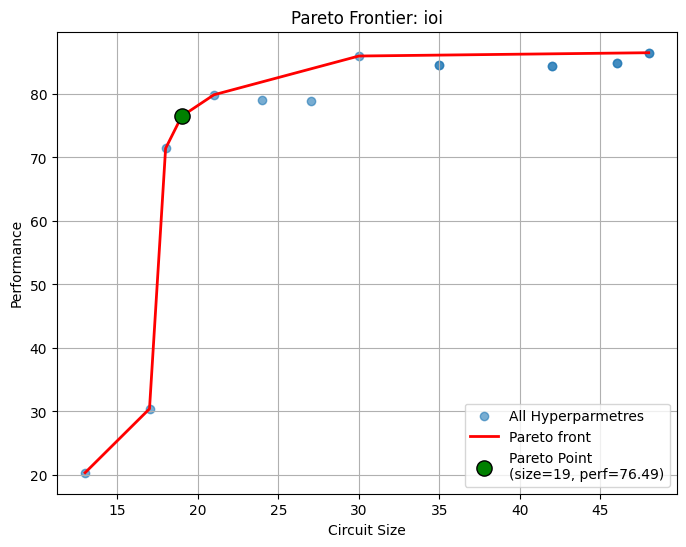

save img at /mnt/lustre/work/eickhoff/esx670/res_final/gpt2/results/APP/pareto_ioi.png


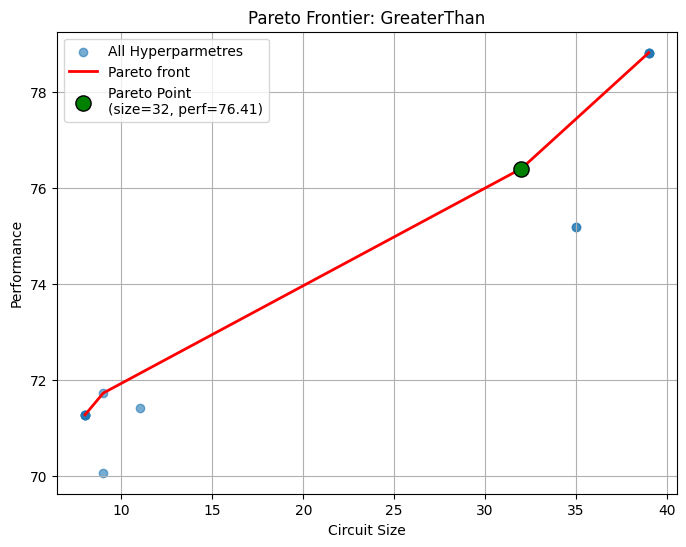

save img at /mnt/lustre/work/eickhoff/esx670/res_final/gpt2/results/APP/pareto_GreaterThan.png


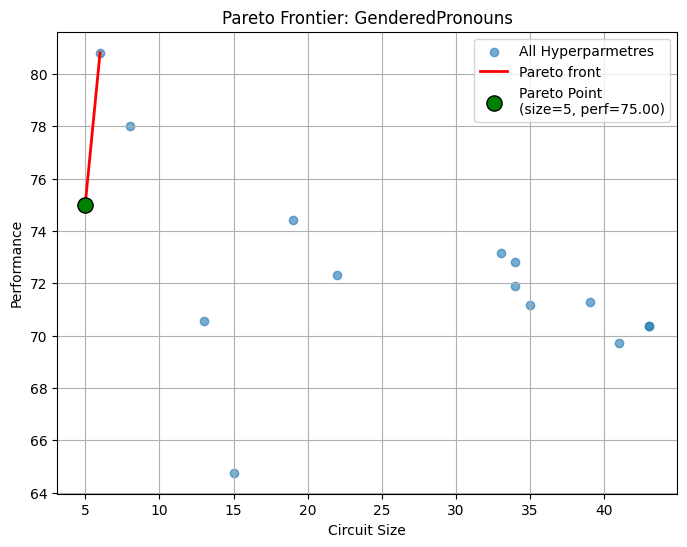

save img at /mnt/lustre/work/eickhoff/esx670/res_final/gpt2/results/APP/pareto_GenderedPronouns.png


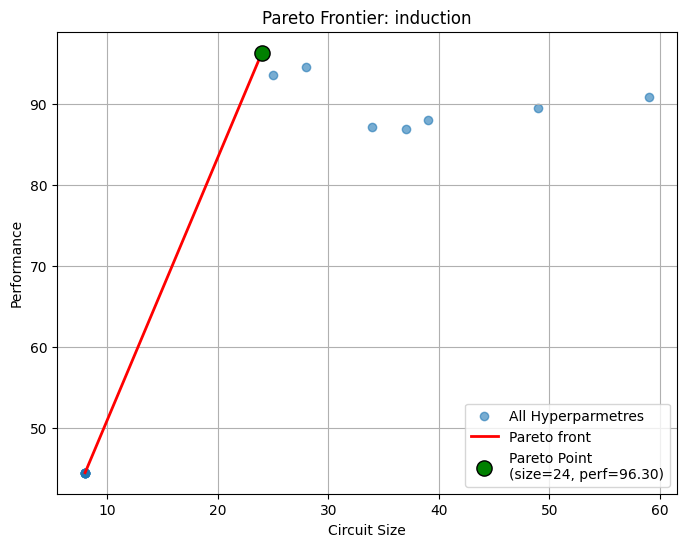

save img at /mnt/lustre/work/eickhoff/esx670/res_final/gpt2/results/APP/pareto_induction.png


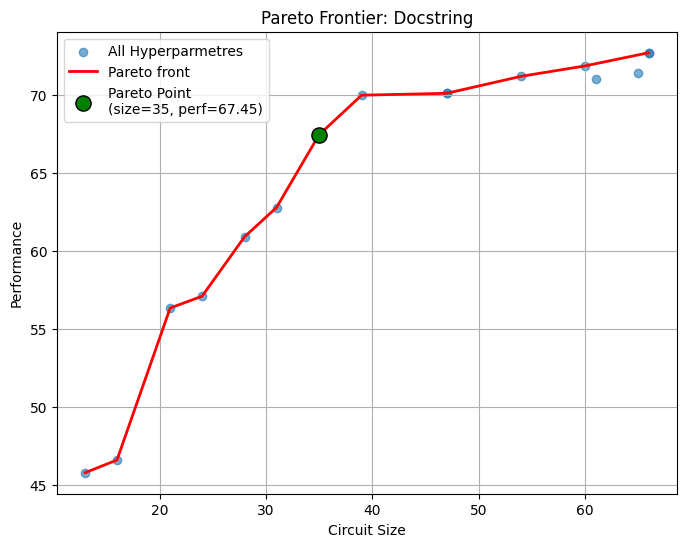

save img at /mnt/lustre/work/eickhoff/esx670/res_final/gpt2/results/APP/pareto_Docstring.png


In [57]:
pareto(APP_df_results, all_tasks, min_performance=75, save_image=True, out_path=f'{out_path}/{model_name}/results/APP/')


# Vanilla + Contrastive FLAP

In [ ]:
vanilla_FLAP = False
contr_FLAP = False

tokenizer = load_tokenizer(model_name)
model_hooked = load_hooked_transformer(model_name, device=device, cache_dir=cache_dir)

cliff_points = ["biggest", "smooth_biggest", "first", "smooth_first", "detect_cliff", "fixed"]

# directory to Path Patching
df_results = pd.DataFrame(columns=["task", "cliff", "performance", "size"])

for task in all_tasks:
    df_results_task = pd.DataFrame(columns=["task", "cliff", "performance", "size"])
    #directory = f"{out_path}/{model_name}/{task}/Hybrid-FLAP" 
    directory = f"{out_path}/{model_name}/{task}/Pruning" 

    eval_dataset = load_dataset(
        prepend_bos=False,
        task=task, 
        patching_method="path",
        tokenizer=tokenizer, 
        N=N, 
        device=device,
        model_name=model_name,
        seed=seed
    )

    # ----- Average Logit Difference of the unpatched Model -----
    with torch.no_grad():
        logits_gt = model_hooked(eval_dataset.clean_tokens)
        
    ave_logit_gt = ave_logit_diff(
        logits=logits_gt, 
        correct_answers=eval_dataset.correct_answers, 
        wrong_answers=eval_dataset.wrong_answers,
        target_idx=eval_dataset.target_idx.to(device), 
        task=task,
        model_name=model_name
        )
    
    for p in cliff_points:
        
        circuit_path = f"{directory}/{p}/sparsity-min_60"        
        if vanilla_FLAP:
            img_name="vanillaFLAP_pareto_points.png"
            CIRCUIT = load_circuit(circuit_path, "clean_circuit.txt")
        elif contr_FLAP:
            img_name="contrastiveFLAP_pareto_points.png"
            CIRCUIT = load_circuit(circuit_path, "ablated_circuit.txt")

        
        size = circuit_size(CIRCUIT)  
        ave_logit, performance = batch_evaluate_circiut(
            model = model_hooked, 
            CIRCUIT=CIRCUIT,
            dataset=eval_dataset,
            ave_logit_gt=ave_logit_gt,
            task=task,
            model_name=model_name, 
            epochs = epochs, 
            batch_size = batch_size 
        )    
            
        new_row = pd.DataFrame({
            "task": [task],
            "cliff": [p],
            "performance": [performance], 
            "size": [size]
        }) 
        
        
        df_results_task = pd.concat([df_results_task, new_row],  ignore_index=True)

    if save_txt:
        store_df(df_results_task, out_path=directory, name="results_FLAP.json")           
        
    if not save_img:
        save_img_path=None
    else:
        save_img_path=directory
        
    df_results = pd.concat([df_results, df_results_task], ignore_index=True)
df_results


load Qwen tokenizer
loading Qwen/Qwen2.5-0.5B as HookedTransformer
use float 16
Loaded pretrained model Qwen/Qwen2.5-0.5B into HookedTransformer
Moving model to device:  cuda
using Qwen/Qwen2.5-0.5B model in IOI dataset


/tmp/ipykernel_3614407/3551355565.py:79: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_results_task = pd.concat([df_results_task, new_row],  ignore_index=True)


DataFrame saved as results_FLAP.json at /mnt/lustre/work/eickhoff/esx670/res_final/Qwen/Qwen2.5-0.5B/ioi/Pruning
loading GreaterThan dataset for Qwen/Qwen2.5-0.5B


/tmp/ipykernel_3614407/3551355565.py:89: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_results = pd.concat([df_results, df_results_task], ignore_index=True)
/tmp/ipykernel_3614407/3551355565.py:79: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_results_task = pd.concat([df_results_task, new_row],  ignore_index=True)


DataFrame saved as results_FLAP.json at /mnt/lustre/work/eickhoff/esx670/res_final/Qwen/Qwen2.5-0.5B/GreaterThan/Pruning
loading GenderedPronouns dataset for Qwen/Qwen2.5-0.5B


/tmp/ipykernel_3614407/3551355565.py:79: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_results_task = pd.concat([df_results_task, new_row],  ignore_index=True)


DataFrame saved as results_FLAP.json at /mnt/lustre/work/eickhoff/esx670/res_final/Qwen/Qwen2.5-0.5B/GenderedPronouns/Pruning
Loading Induction Dataset with Qwen/Qwen2.5-0.5B


/tmp/ipykernel_3614407/3551355565.py:79: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_results_task = pd.concat([df_results_task, new_row],  ignore_index=True)


DataFrame saved as results_FLAP.json at /mnt/lustre/work/eickhoff/esx670/res_final/Qwen/Qwen2.5-0.5B/induction/Pruning


/tmp/ipykernel_3614407/3551355565.py:79: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_results_task = pd.concat([df_results_task, new_row],  ignore_index=True)


DataFrame saved as results_FLAP.json at /mnt/lustre/work/eickhoff/esx670/res_final/Qwen/Qwen2.5-0.5B/Docstring/Pruning


,task,cliff,performance,size
0,ioi,biggest,39.053254,33
1,ioi,smooth_biggest,58.653846,38
2,ioi,first,75.702663,148
3,ioi,smooth_first,76.997041,113
4,ioi,detect_cliff,70.266272,172
5,ioi,fixed,59.837278,121
6,GreaterThan,biggest,76.265579,125
7,GreaterThan,smooth_biggest,20.105946,55
8,GreaterThan,first,76.823196,131
9,GreaterThan,smooth_first,76.568288,133


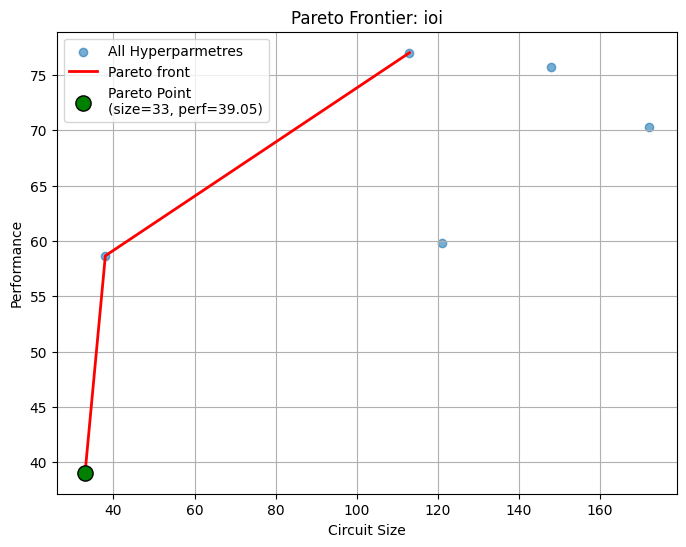

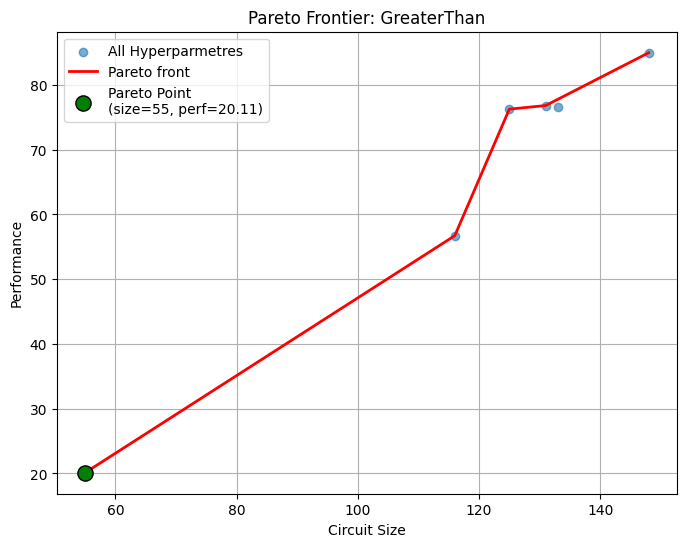

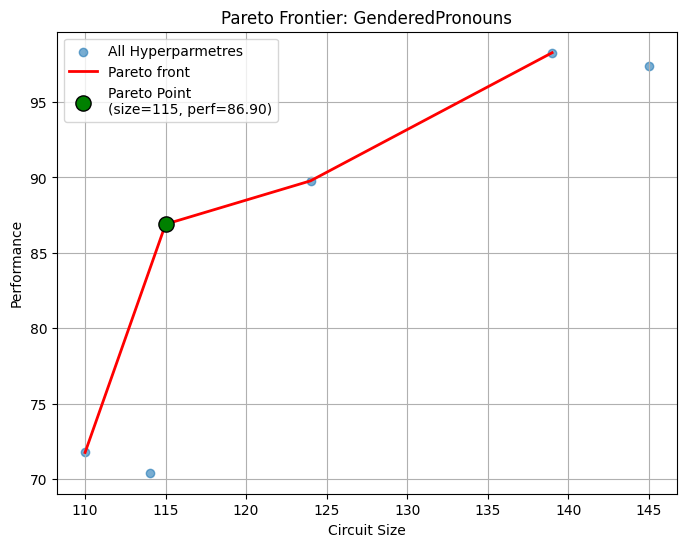

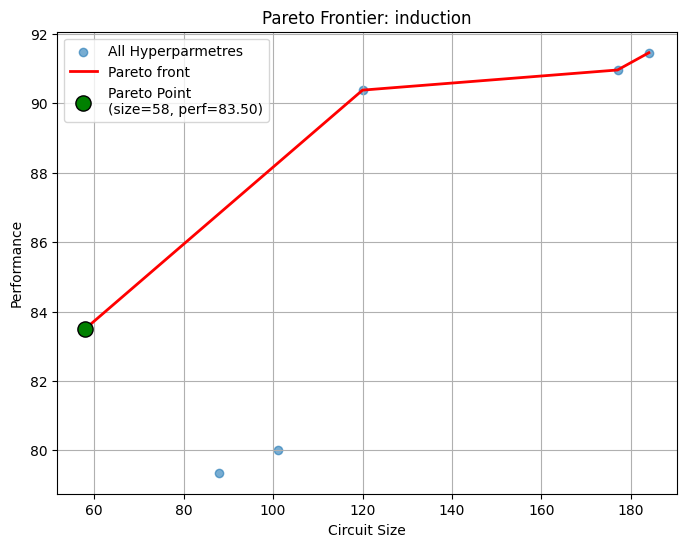

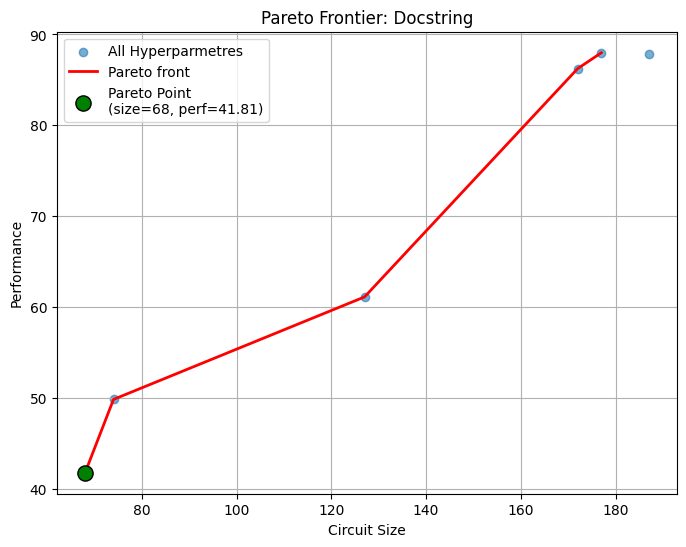

In [8]:
pareto(df_results, all_tasks, min_performance=0.75)

# Hybrid FLAP

In [233]:
from utils.eval_circuit import merge_circuits

test_vanilla_FLAP = False

tokenizer = load_tokenizer(model_name)
model_hooked = load_hooked_transformer(model_name, device=device, cache_dir=cache_dir)

cliff_points1 = ["fixed", "biggest", "first"] #["smooth_first", "smooth_biggest", "detect_cliff", "fixed", "biggest", "first", ]
cliff_points2 = ["fixed", "biggest", "first"] #["smooth_first", "smooth_biggest", "detect_cliff", "fixed", "biggest", "first", ]

# directory to Path Patching
df_results = pd.DataFrame(columns=["task", "cliff_vanilla", "cliff_contrastive", "performance", "size"])

for task in all_tasks:
    df_results_task = pd.DataFrame(columns=["task","cliff_vanilla", "cliff_contrastive", "performance", "size"])
    #directory = f"{out_path}/{model_name}/{task}/Hybrid-FLAP" 
    directory = f"{out_path}/{model_name}/{task}/Pruning" 

    eval_dataset = load_dataset(
        prepend_bos=False,
        task=task, 
        patching_method="path",
        tokenizer=tokenizer, 
        N=N, 
        device=device,
        model_name=model_name,
        seed=seed
    )

    # ----- Average Logit Difference of the unpatched Model -----
    with torch.no_grad():
        logits_gt = model_hooked(eval_dataset.clean_tokens)
        
    ave_logit_gt = ave_logit_diff(
        logits=logits_gt, 
        correct_answers=eval_dataset.correct_answers, 
        wrong_answers=eval_dataset.wrong_answers,
        target_idx=eval_dataset.target_idx.to(device), 
        task=task,
        model_name=model_name
        )
    
    for p1 in cliff_points1:
        for p2 in cliff_points2:
                    
            img_name="hybrid_FLAP_points.png"
            circuit_path = f"{directory}/{p1}/sparsity-min_60/" 
            CIRCUIT_VANILLA = load_circuit(circuit_path, "clean_circuit.txt")
            
            circuit_path = f"{directory}/{p2}/sparsity-min_60/" 
            CIRCUIT_CONTR = load_circuit(circuit_path, "contrastive_circuit.txt")
            
            CIRCUIT = merge_circuits(CIRCUIT_VANILLA, CIRCUIT_CONTR)
            
            size = circuit_size(CIRCUIT)  
            ave_logit, performance = batch_evaluate_circiut(
                model = model_hooked, 
                CIRCUIT=CIRCUIT,
                dataset=eval_dataset,
                ave_logit_gt=ave_logit_gt,
                task=task,
                model_name=model_name, 
                epochs = epochs, 
                batch_size = batch_size 
            )    
                
            new_row = pd.DataFrame({
                "task": [task],
                "cliff_vanilla": [p1],
                "cliff_contrastive": [p2],
                "performance": [performance], 
                "size": [size]
            }) 
            
            
            df_results_task = pd.concat([df_results_task, new_row],  ignore_index=True)

    if save_txt:
        store_df(df_results_task, out_path=directory, name="results_hybridFLAP.json")           
        
    if not save_img:
        save_img_path=None
    else:
        save_img_path=directory

    df_results = pd.concat([df_results, df_results_task], ignore_index=True)
df_results

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

load Qwen tokenizer
loading Qwen/Qwen2.5-7B as HookedTransformer
use float 16


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loaded pretrained model Qwen/Qwen2.5-7B into HookedTransformer
Moving model to device:  cuda
using Qwen/Qwen2.5-7B model in IOI dataset


/tmp/ipykernel_1119446/968941214.py:76: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_results_task = pd.concat([df_results_task, new_row],  ignore_index=True)


DataFrame saved as results_hybridFLAP.json at /mnt/lustre/work/eickhoff/esx670/res_final/Qwen/Qwen2.5-7B/ioi/Pruning
loading GreaterThan dataset for Qwen/Qwen2.5-7B


/tmp/ipykernel_1119446/968941214.py:86: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_results = pd.concat([df_results, df_results_task], ignore_index=True)
/tmp/ipykernel_1119446/968941214.py:76: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_results_task = pd.concat([df_results_task, new_row],  ignore_index=True)


DataFrame saved as results_hybridFLAP.json at /mnt/lustre/work/eickhoff/esx670/res_final/Qwen/Qwen2.5-7B/GreaterThan/Pruning
loading GenderedPronouns dataset for Qwen/Qwen2.5-7B


/tmp/ipykernel_1119446/968941214.py:76: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_results_task = pd.concat([df_results_task, new_row],  ignore_index=True)


DataFrame saved as results_hybridFLAP.json at /mnt/lustre/work/eickhoff/esx670/res_final/Qwen/Qwen2.5-7B/GenderedPronouns/Pruning
Loading Induction Dataset with Qwen/Qwen2.5-7B


/tmp/ipykernel_1119446/968941214.py:76: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_results_task = pd.concat([df_results_task, new_row],  ignore_index=True)


DataFrame saved as results_hybridFLAP.json at /mnt/lustre/work/eickhoff/esx670/res_final/Qwen/Qwen2.5-7B/induction/Pruning


/tmp/ipykernel_1119446/968941214.py:76: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_results_task = pd.concat([df_results_task, new_row],  ignore_index=True)


DataFrame saved as results_hybridFLAP.json at /mnt/lustre/work/eickhoff/esx670/res_final/Qwen/Qwen2.5-7B/Docstring/Pruning


,task,cliff_vanilla,cliff_contrastive,performance,size
0,ioi,fixed,fixed,81.109185,290
1,ioi,fixed,biggest,77.007510,303
2,ioi,fixed,first,78.509532,338
3,ioi,biggest,fixed,82.668977,346
4,ioi,biggest,biggest,78.856153,356
5,ioi,biggest,first,79.549393,383
6,ioi,first,fixed,83.419988,366
7,ioi,first,biggest,78.971693,375
8,ioi,first,first,78.162912,398
9,GreaterThan,fixed,fixed,92.371621,263


## Pareto

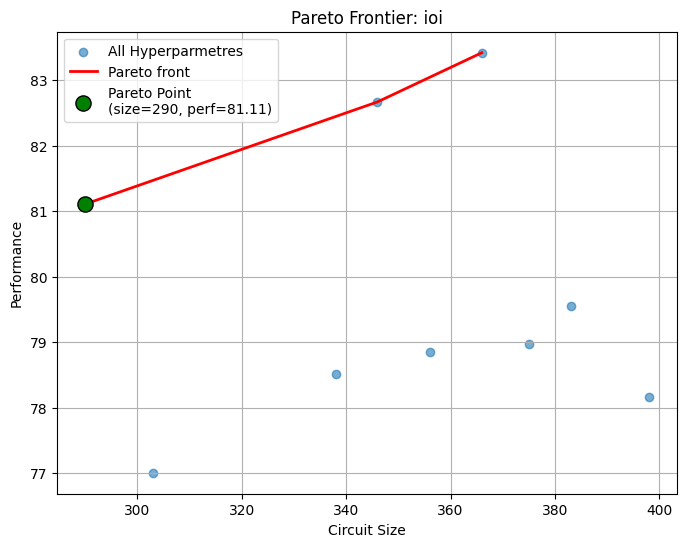

save img at /mnt/lustre/work/eickhoff/esx670/res_final/Qwen/Qwen2.5-7B/results/hybrid_FLAP/pareto_ioi.png


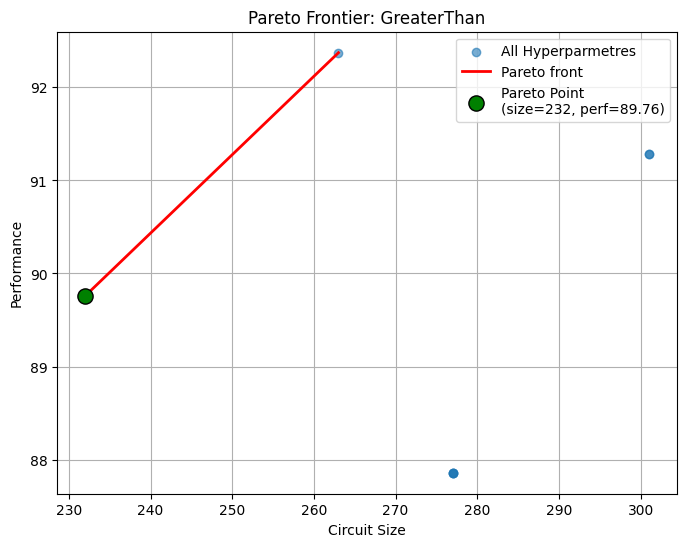

save img at /mnt/lustre/work/eickhoff/esx670/res_final/Qwen/Qwen2.5-7B/results/hybrid_FLAP/pareto_GreaterThan.png


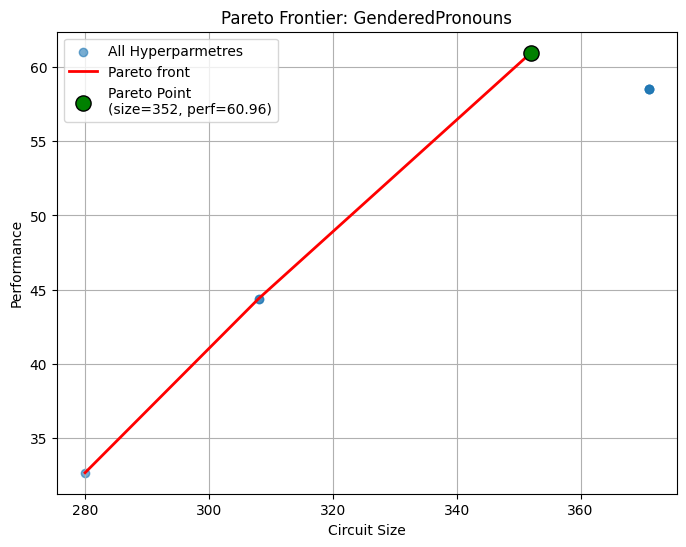

save img at /mnt/lustre/work/eickhoff/esx670/res_final/Qwen/Qwen2.5-7B/results/hybrid_FLAP/pareto_GenderedPronouns.png


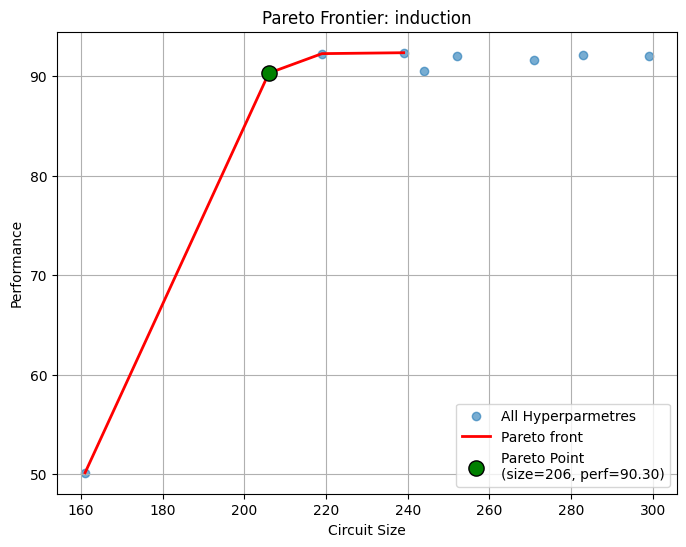

save img at /mnt/lustre/work/eickhoff/esx670/res_final/Qwen/Qwen2.5-7B/results/hybrid_FLAP/pareto_induction.png


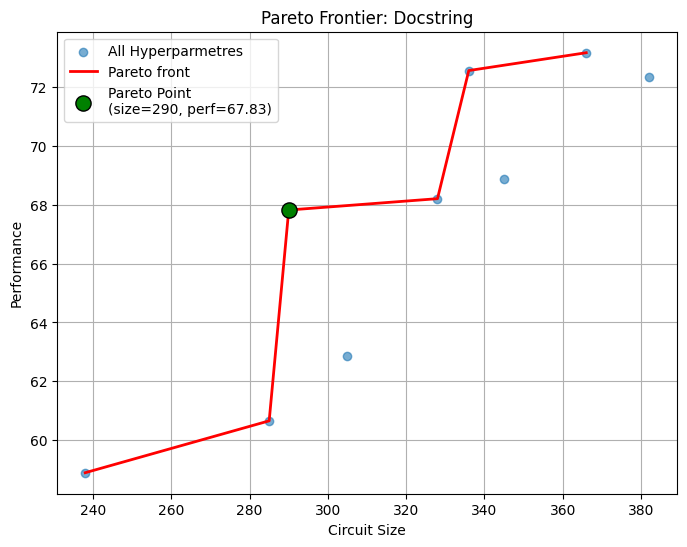

save img at /mnt/lustre/work/eickhoff/esx670/res_final/Qwen/Qwen2.5-7B/results/hybrid_FLAP/pareto_Docstring.png


In [234]:
pareto(df_results, all_tasks, min_performance=75, save_image=True, out_path=f'{out_path}/{model_name}/results/hybrid_FLAP/')


In [236]:
with open(f'{out_path}/{model_name}/results/hybrid_FLAP/hybridFLAP.txt', 'a') as f:
    f.write(df_results.to_string(header=False, index=False))

# All Methods, one task

In [84]:
eval_tokenizer = load_tokenizer(model_name)
model_hooked = load_hooked_transformer(model_name, device=device, cache_dir=cache_dir)

load Qwen tokenizer
loading Qwen/Qwen2.5-7B as HookedTransformer
use float 16


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loaded pretrained model Qwen/Qwen2.5-7B into HookedTransformer
Moving model to device:  cuda


In [83]:
#model_name="Qwen/Qwen2.5-0.5B"
model_name="Qwen/Qwen2.5-7B"
#model_name="gpt2-large"
#model_name="gpt2"

    
# --------------- task -----------------#

#task="GenderedPronouns"
#task="induction"
#task="GreaterThan"
#task="ioi"
task="Docstring"


In [85]:
gc.collect()
torch.cuda.empty_cache()

# ---- Path PAtching and FLAP ------
PP_FLAP_CIRCUIT = choose_PP_FLAP_circuit(task, model_name)
PP_FLAP_path = get_result_path_PP_FLAP(task, model_name)
PP_FLAP_results = load_df(PP_FLAP_path, "results.json")

# ------ Path PAtching -----
PP_CIRCUIT = choose_circuit(task, model_name)
PP_path = get_result_path_PP(task, model_name)
PP_result = load_df(PP_path, "results.json")

# ----- FLAP and Hybrid FLAP ------
#HYBRID_FLAP_CIRCUIT = choose_hybrid_FLAP_circuit(task, model_name)
FLAP_CIRCUIT = choose_FLAP_clean_circuit(task, model_name)
FLAP_CIRCUIT_CORR =  choose_FLAP_substracted_circuit(task, model_name)
HYBRID_FLAP_CIRCUIT = merge_circuits(FLAP_CIRCUIT, FLAP_CIRCUIT_CORR)

FLAP_path = get_result_path_FLAP(task, model_name)
FLAP_df = load_df(FLAP_path, "results.json")

HYBRID_FLAP_results = FLAP_df[FLAP_df["pruning_type"] == "hybrid"] 
FLAP_results =  FLAP_df[FLAP_df["pruning_type"] == "clean"] 

path /mnt/lustre/work/eickhoff/esx670/res_final
path /mnt/lustre/work/eickhoff/esx670/res_final
/mnt/lustre/work/eickhoff/esx670/res_final/Qwen/Qwen2.5-7B/Docstring/FLAP_Path_Patching/logits_diff/sqrt/min_threshold-0.001/k_2-scale_1.5/results.json
path /mnt/lustre/work/eickhoff/esx670/res_final/Qwen/Qwen2.5-7B/Docstring/path/automatic/logits_diff/sqrt/min_threshold-0.001/k_2-scale_1.5/
/mnt/lustre/work/eickhoff/esx670/res_final/Qwen/Qwen2.5-7B/Docstring/path/automatic/logits_diff/sqrt/min_threshold-0.001/k_2-scale_1.5/results.json
/mnt/lustre/work/eickhoff/esx670/res_final/Qwen/Qwen2.5-7B/Docstring/Hybrid-FLAP/first/sparsity-min_60/sparsity-max_99/
/mnt/lustre/work/eickhoff/esx670/res_final/Qwen/Qwen2.5-7B/Docstring/Hybrid-FLAP/fixed/sparsity-min_60/sparsity-max_99/results.json


In [87]:
from utils.eval_circuit import performance_achieved

df = pd.DataFrame(columns=["circuit", "performance", "size", "sparsity", "TPR"])#, "GFLOPS", "time"])
    
# ----- FLAP Circuit -----
print("FLAP CIRCUIT")
eval_dataset = load_dataset(
    prepend_bos=False,
    task=task, 
    patching_method="path",
    tokenizer=eval_tokenizer, 
    N=N, 
    device=device,
    model_name=model_name,
    seed=seed
    )

with torch.no_grad():
    logits_gt = model_hooked(eval_dataset.clean_tokens)
    
ave_logit_gt = ave_logit_diff(
    logits=logits_gt, 
    correct_answers=eval_dataset.correct_answers,
    wrong_answers=eval_dataset.wrong_answers,
    target_idx=eval_dataset.target_idx.to(device),
    task=task,
    model_name=model_name
    )

print("Average logit difference original model: ", ave_logit_gt)
# ------ HYBRID FLAP CIRCUIT ------
print("HYBRID FLAP")


ave_logit, performance = batch_evaluate_circiut(
    model = model_hooked, 
    CIRCUIT=HYBRID_FLAP_CIRCUIT,
    dataset=eval_dataset,
    ave_logit_gt=ave_logit_gt,
    task=task,
    model_name=model_name, 
    epochs = epochs, 
    batch_size = batch_size 
)

hybrid_FLAP_size = circuit_size(HYBRID_FLAP_CIRCUIT)
performance = performance_achieved(ave_logit_gt, ave_logit)
new_row = pd.DataFrame([{"circuit": "Hybrid-FLAP",
                        "performance": performance,#HYBRID_FLAP_results["performance"].item(), 
                        "size":hybrid_FLAP_size,
                        "sparsity":1-(hybrid_FLAP_size/total_model_size),
                        "TPR": TPR(circuit=HYBRID_FLAP_CIRCUIT, GT_circuit=PP_CIRCUIT), 
                        #"GFLOPS": HYBRID_FLAP_results["FLOP"].item(), 
                        #"time": HYBRID_FLAP_results["comp_time"].item()
                        }])

df = pd.concat([df, new_row], ignore_index=True)

# ----- APP ------
print("Accelerated Path Patching")

ave_logit, performance = batch_evaluate_circiut(
    model = model_hooked, 
    CIRCUIT=PP_FLAP_CIRCUIT,
    dataset=eval_dataset,
    ave_logit_gt=ave_logit_gt,
    task=task,
    model_name=model_name, 
    epochs = epochs, 
    batch_size = batch_size 
)
performance= performance_achieved(ave_logit_gt, ave_logit)
APP_size = circuit_size(PP_FLAP_CIRCUIT)

new_row = pd.DataFrame([{"circuit": "Accerelerated Path Patching",
                        "performance":performance,# PP_FLAP_results["performance_cicrcuit"].item(), 
                        "size": APP_size,
                        "sparsity": 1-(APP_size/total_model_size),
                        "TPR": TPR(circuit=PP_FLAP_CIRCUIT, GT_circuit=PP_CIRCUIT), 
                        #"GFLOPS": PP_FLAP_results["GFLOP"].item() + HYBRID_FLAP_results["FLOP"].item(), 
                        #"time": PP_FLAP_results["comp_time"].item() + HYBRID_FLAP_results["comp_time"].item()
                        }])

df = pd.concat([df, new_row], ignore_index=True)

# ------ Path Pathcing ------

ave_logit, performance = batch_evaluate_circiut(
    model = model_hooked, 
    CIRCUIT=PP_CIRCUIT,
    dataset=eval_dataset,
    ave_logit_gt=ave_logit_gt,
    task=task,
    model_name=model_name, 
    epochs = epochs, 
    batch_size = batch_size 
)
PP_size = circuit_size(PP_CIRCUIT)
performance= performance_achieved(ave_logit_gt, ave_logit)
print("Path Patching")
new_row = pd.DataFrame([{"circuit": "Path Patching",
                        "performance": performance,# PP_result["performance_cicrcuit"].item(), 
                        "size": PP_size,
                        "sparsity": 1-(PP_size/total_model_size),
                        "TPR": TPR(circuit=PP_CIRCUIT, GT_circuit=PP_CIRCUIT), 
                        #"GFLOPS":PP_result["GFLOP"].item(), 
                        #"time": PP_result["comp_time"].item()
                        }])

df = pd.concat([df, new_row], ignore_index=True)
df

FLAP CIRCUIT
Average logit difference original model:  7.078125
HYBRID FLAP


/tmp/ipykernel_306090/2165275484.py:57: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


Accelerated Path Patching
Path Patching


,circuit,performance,size,sparsity,TPR
0,Hybrid-FLAP,73.565121,336,0.571429,0.793333
1,Accerelerated Path Patching,48.647903,83,0.894133,0.526667
2,Path Patching,64.790287,150,0.808673,1.000000


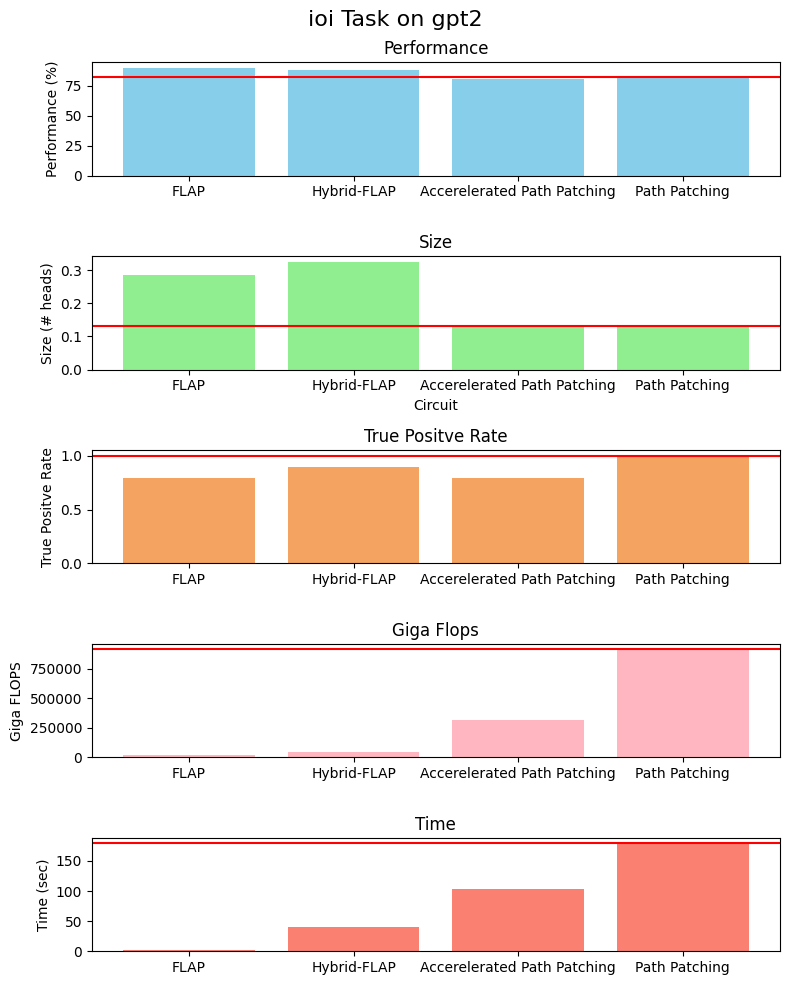

save img at /mnt/lustre/work/eickhoff/esx670/res_final/gpt2/ioi/results.png
DataFrame saved as results.json at /mnt/lustre/work/eickhoff/esx670/res_final/gpt2/ioi


In [ ]:
fig, axes = plt.subplots(5, 1, figsize=(8, 10), sharex=False)

# Plot 1: performance
axes[0].bar(df['circuit'], df['performance'], color='skyblue')
axes[0].axhline(y=df[df["circuit"] == "Path Patching"]["performance"].item(), color="red")
axes[0].set_ylabel('Performance (%)')
axes[0].set_title('Performance')

# Plot 2: size
axes[1].bar(df['circuit'], df['size'], color='lightgreen')
axes[1].set_ylabel('Size (# heads)')
axes[1].set_title('Size')
axes[1].set_xlabel('Circuit')
axes[1].axhline(y=df[df["circuit"] == "Path Patching"]["size"].item(), color="red")

# Plot 4: TPR
axes[2].bar(df['circuit'], df['TPR'], color='sandybrown')
axes[2].set_ylabel('True Positve Rate')
axes[2].set_title('True Positve Rate')
axes[2].axhline(y=df[df["circuit"] == "Path Patching"]["TPR"].item(), color="red")


# Plot 4: GLFLOPs
axes[3].bar(df['circuit'], df['GFLOPS'], color='lightpink')
axes[3].set_ylabel('Giga FLOPS')
axes[3].set_title('Giga Flops')
axes[3].axhline(y=df[df["circuit"] == "Path Patching"]["GFLOPS"].item(), color="red")


# Plot 5: time
axes[4].bar(df['circuit'], df['time'], color='salmon')
axes[4].set_ylabel('Time (sec)')
axes[4].set_title('Time')
axes[4].axhline(y=df[df["circuit"] == "Path Patching"]["time"].item(), color="red")


fig.suptitle(f"{task} Task on {model_name}", fontsize=16)
plt.tight_layout()
plt.show()

path = f"{out_path}/{model_name}/{task}"
if save_image:
    save_img(fig, out_path=path, name="results.png")
if save_txt:
    store_df(df, out_path=path, name="results.json")

# All Methods, all task mean

In [14]:
from circuit_PP_FLAP import choose_PP_FLAP_circuit, get_result_path_PP_FLAP
from circuits import choose_circuit, get_result_path_PP
from circuits_FLAP import choose_FLAP_circuit, choose_hybrid_FLAP_circuit, get_result_path_FLAP
from utils.utils import load_df
from utils.model_loader import get_gpt2_adapt_to_llama, load_tokenizer, load_hooked_transformer, load_transformer
from utils.eval_circuit import TPR

df = pd.DataFrame(columns=["task", "circuit", "performance", "size", "TPR", "GFLOPS", "time"])
    
# ----- Test that the correct prediction is made -----
for task in ["ioi", "GreaterThan", "induction", "GenderedPronouns"]:

    print("total model size",total_model_size)
    #for task in ["GreaterThan",  "induction", "GenderedPronouns"]:
    
    # ---- Path PAtching and FLAP ------
    PP_FLAP_CIRCUIT = choose_PP_FLAP_circuit(task, model_name)
    PP_FLAP_path = get_result_path_PP_FLAP(task, model_name)
    PP_FLAP_results = load_df(PP_FLAP_path, "results.json")

    # ------ Path PAtching -----
    PP_CIRCUIT = choose_circuit(task, model_name)
    PP_path = get_result_path_PP(task, model_name)
    PP_result = load_df(PP_path, "results.json")

    # ----- FLAP and Hybrid FLAP ------
    HYBRID_FLAP_CIRCUIT = choose_hybrid_FLAP_circuit(task, model_name)
    FLAP_CIRCUIT = choose_FLAP_circuit(task, model_name)
    FLAP_path = get_result_path_FLAP(task, model_name)
    FLAP_df = load_df(FLAP_path, "results.json")

    HYBRID_FLAP_results = FLAP_df[FLAP_df["pruning_type"] == "hybrid"] 
    FLAP_results =  FLAP_df[FLAP_df["pruning_type"] == "clean"] 

    # ----- FLAP Circuit -----
    
    new_row = pd.DataFrame([{
        "task": task,
        "circuit": "FLAP",
        "performance": FLAP_results["performance"].item(), 
        #"performance":performance,
        "size": FLAP_results["size"].item()/total_model_size,
        "TPR": TPR(circuit=FLAP_CIRCUIT, GT_circuit=PP_CIRCUIT), 
        "GFLOPS": FLAP_results["FLOP"].item(), 
        "time": FLAP_results["comp_time"].item()   
        }])

    df = pd.concat([df, new_row], ignore_index=True)

    new_row = pd.DataFrame([{
        "task": task,
        "circuit": "Hybrid-FLAP",
        "performance": HYBRID_FLAP_results["performance"].item(), 
        #"performance":performance,
        "size": HYBRID_FLAP_results["size"].item()/total_model_size,
        "TPR": TPR(circuit=HYBRID_FLAP_CIRCUIT, GT_circuit=PP_CIRCUIT), 
        "GFLOPS": HYBRID_FLAP_results["FLOP"].item(), 
        "time": HYBRID_FLAP_results["comp_time"].item()
        }])

    df = pd.concat([df, new_row], ignore_index=True)

    # ----- APP ------

    
    new_row = pd.DataFrame([{
        "task": task,
        "circuit": "APP",
        "performance": PP_FLAP_results["performance_cicrcuit"].item(), 
        #"performance":performance,
        "size": PP_FLAP_results["size_circuit"].item()/total_model_size,
        "TPR": TPR(circuit=PP_FLAP_CIRCUIT, GT_circuit=PP_CIRCUIT), 
        "GFLOPS": PP_FLAP_results["GFLOP"].item() + HYBRID_FLAP_results["FLOP"].item(), 
        "time": PP_FLAP_results["comp_time"].item() + HYBRID_FLAP_results["comp_time"].item()
        }])
    
    df = pd.concat([df, new_row], ignore_index=True)

    # ------ Path Pathcing ------

    
    print(PP_result)
    new_row = pd.DataFrame([{
        "task": task,
        "circuit": "PP",
        "performance": PP_result["performance_cicrcuit"].item(), 
        #"performance":performance,
        "size": PP_result["size_circuit"].item()/total_model_size,
        "TPR": TPR(circuit=PP_CIRCUIT, GT_circuit=PP_CIRCUIT), 
        "GFLOPS":PP_result["GFLOP"].item(), 
        "time": PP_result["comp_time"].item()
        }])

    df = pd.concat([df, new_row], ignore_index=True)

df_mean = df.loc[:, df.columns != "task"].groupby(["circuit"]).mean()
path = f"{out_path}/{model_name}"
if save_txt:
    store_df(df, out_path=path, name="all_tasks_results.json")
    if model_name=="Qwen/Qwen2.5-0.5B":
        res_name="Qwen2.5-0.5B"
    elif model_name=="Qwen/Qwen2.5-7B":
        res_name="Qwen2.5-7B"
    else:
        res_name=model_name
    df_mean.reset_index().to_json(f"{path}/means_{res_name}.json", orient="records")     
    

print(df)
df_mean


ModuleNotFoundError: No module named 'circuit_PP_FLAP'

# barplot of GFLOPS

In [171]:
#model_name="Qwen/Qwen2.5-0.5B"
model_name="Qwen/Qwen2.5-7B"
#model_name="gpt2-large"
#model_name="gpt2"

efficency_metric = "comp_time" #"GFLOPS" # comp_time


In [172]:
min_activations = [0.01, 0.001, 0.02, 0.002]
scales = [1, 1.5, 2, 2.5]
df_results_pp = pd.DataFrame(columns=["model_name", "task", "min_act", "scale", "GFLOPS", "comp_time"])

for t in all_tasks:
    directory = f"{out_path}/{model_name}/{t}/path/automatic/logits_diff/sqrt/"   # ioi

    for ma in min_activations:
        for s in scales:
            exists=True            
            circuit_path = f"{directory}/min_threshold-{ma}/k_2-scale_{s}/"        
            #print("path", circuit_path)
            res_file_path = os.path.join(circuit_path, "results.json")
            try:
                CIRCUIT = load_circuit(circuit_path, "circuit.txt")
                df = pd.read_json(res_file_path, orient="records") 
                new_row = pd.DataFrame({
                    "model_name": model_name,
                    "task": t,
                    "min_act": ma, 
                    "scale": s, 
                    "GFLOPS": df["GFLOP"],
                    "comp_time": df["comp_time"]
                })
                df_results_pp = pd.concat([df_results_pp, new_row],  ignore_index=True)
                    
            except:
                print("result was not stored for", circuit_path)
                exists=False
                continue
            
            if not exists:
                print("no result for Accerlerated Path Patching", model_name, t,  ma, s)  
print(df_results_pp)


df_results_pp_sum = df_results_pp.groupby(["task"]).sum()
df_results_pp_sum


for t in ["ioi", "GreaterThan", "GenderedPronouns", "induction", "Docstring"]:
    if not len(df_results_pp[df_results_pp["task"] == t]) == len(min_activations) * len(scales):
        print(t, "has not the correct length")
        print(df_results_pp[df_results_pp["task"] == t])
        
        
if save_txt:
    store_df(df_results_pp, out_path=f"{out_path}/{model_name}", name="speed_PP.json")         


/tmp/ipykernel_306090/3254478223.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_results_pp = pd.concat([df_results_pp, new_row],  ignore_index=True)


         model_name       task  min_act scale        GFLOPS      comp_time
0   Qwen/Qwen2.5-7B        ioi    0.010     1  6.842750e+08   34770.517622
1   Qwen/Qwen2.5-7B        ioi    0.010   1.5  4.611969e+08   22081.132707
2   Qwen/Qwen2.5-7B        ioi    0.010     2  3.852687e+08   18044.977995
3   Qwen/Qwen2.5-7B        ioi    0.010   2.5  3.547129e+08   16446.158804
4   Qwen/Qwen2.5-7B        ioi    0.001     1  1.424783e+09   77673.485331
..              ...        ...      ...   ...           ...            ...
75  Qwen/Qwen2.5-7B  Docstring    0.020   2.5  3.180290e+08   12141.917965
76  Qwen/Qwen2.5-7B  Docstring    0.002     1  2.092774e+09  105553.739661
77  Qwen/Qwen2.5-7B  Docstring    0.002   1.5  6.658723e+08   31334.704835
78  Qwen/Qwen2.5-7B  Docstring    0.002     2  6.182570e+08   28781.305054
79  Qwen/Qwen2.5-7B  Docstring    0.002   2.5  6.733691e+08   29801.895599

[80 rows x 6 columns]
DataFrame saved as speed_PP.json at /mnt/lustre/work/eickhoff/esx670/res_fina

In [173]:
min_activations = [0.01, 0.001, 0.02, 0.002]
scales = [1, 1.5, 2, 2.5]
df_results_app = pd.DataFrame(columns=["model_name", "task", "min_act", "scale", "GFLOPS", "comp_time"])

for t in all_tasks:
    directory = f"{out_path}/{model_name}/{t}/FLAP_Path_Patching/logits_diff/sqrt/"   # ioi

    for ma in min_activations:
        for s in scales:
            exists=True            
            circuit_path = f"{directory}/min_threshold-{ma}/k_2-scale_{s}/"        
            #print("path", circuit_path)
            res_file_path = os.path.join(circuit_path, "results.json")
            try:
                CIRCUIT = load_circuit(circuit_path, "circuit.txt")
                df = pd.read_json(res_file_path, orient="records") 
                new_row = pd.DataFrame({
                    "model_name": model_name,
                    "task": t,
                    "min_act": ma, 
                    "scale": s, 
                    "GFLOPS": df["GFLOP"],
                    "comp_time": df["comp_time"]
                })
                df_results_app = pd.concat([df_results_app, new_row],  ignore_index=True)
                    
            except:
                print("result was not stored for", circuit_path)
                exists=False
                continue
            
            if not exists:
                print("no result for Accerlerated Path Patching", model_name, t,  ma, s)  
print(df_results_app)


df_results_app_sum = df_results_app.groupby(["task"]).sum()
df_results_app_sum


for t in ["ioi", "GreaterThan", "GenderedPronouns", "induction", "Docstring"]:
    if not len(df_results_app[df_results_app["task"] == t]) == len(min_activations) * len(scales):
        print(t, "has not the correct length")
        print(df_results_app[df_results_app["task"] == t])
        
        
if save_txt:
    store_df(df_results_app, out_path=f"{out_path}/{model_name}", name="speed_APP.json")         


/tmp/ipykernel_306090/3085430245.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_results_app = pd.concat([df_results_app, new_row],  ignore_index=True)


         model_name       task  min_act scale        GFLOPS     comp_time
0   Qwen/Qwen2.5-7B        ioi    0.010     1  1.587366e+08   7926.059054
1   Qwen/Qwen2.5-7B        ioi    0.010   1.5  1.251887e+08   6187.146937
2   Qwen/Qwen2.5-7B        ioi    0.010     2  1.110630e+08   5312.480097
3   Qwen/Qwen2.5-7B        ioi    0.010   2.5  8.379778e+07   3618.878561
4   Qwen/Qwen2.5-7B        ioi    0.001     1  2.386328e+08  13002.237013
..              ...        ...      ...   ...           ...           ...
75  Qwen/Qwen2.5-7B  Docstring    0.020   2.5  1.261972e+08   4816.352112
76  Qwen/Qwen2.5-7B  Docstring    0.002     1  2.907556e+08  15151.089181
77  Qwen/Qwen2.5-7B  Docstring    0.002   1.5  1.598397e+08   7455.808054
78  Qwen/Qwen2.5-7B  Docstring    0.002     2  1.441349e+08   6582.644983
79  Qwen/Qwen2.5-7B  Docstring    0.002   2.5  1.833855e+08   7729.507659

[80 rows x 6 columns]
DataFrame saved as speed_APP.json at /mnt/lustre/work/eickhoff/esx670/res_final/Qwen/Qwen

In [ ]:
df_combined = pd.DataFrame({"PP": df_results_pp_sum[efficency_metric], "APP": df_results_app_sum[efficency_metric]})
df_combined
# Calculate speedup
df_combined['Speedup'] = df_combined['PP'] / df_combined['APP']
df_combined = df_combined.rename(index={
    "Docstring": "Docstring",
    "GenderedPronouns": "GenderedPronouns",  # add space
    "GreaterThan": "GreaterThan",            # add space
    "induction": "Induction",                 # capitalize
    "ioi": "IOI"                              # uppercase
})

df_combined = df_combined.sort_values(by="PP", ascending=False)
efficency_barplots(df_combined, model_name=model_name, efficency_metric="GFLOPS")


# Manual vs Automatic Path Patching

In [34]:
#model_name="Qwen/Qwen2.5-0.5B"
#model_name="Qwen/Qwen2.5-7B"
#model_name="gpt2-large"
model_name="gpt2"

from utils.eval_circuit import performance_achieved, circuit_size, get_intersection_num
N=200

eval_tokenizer = load_tokenizer(model_name)
model_hooked = load_hooked_transformer(model_name, device=device, cache_dir=cache_dir)



for t in all_tasks:
    print("for loop task", t)
    print("\n \n" , "#" * 50, "\n")
    MANUAL_CIRCUIT = get_manual_PP_circuit(t, model_name)
    AUTOMATIC_CIRCUIT = choose_circuit(t, model_name)
    circuit_name = get_circuit_name(t)
    
    eval_dataset = load_dataset(
        prepend_bos=False,
        task=t, 
        patching_method="path",
        tokenizer=eval_tokenizer, 
        N=N, 
        device=device,
        model_name=model_name,
        seed=seed
        )
    
    with torch.no_grad():
        logits_gt = model_hooked(eval_dataset.clean_tokens)
        
    ave_logit_gt = ave_logit_diff(
        logits=logits_gt, 
        correct_answers=eval_dataset.correct_answers, 
        wrong_answers=eval_dataset.wrong_answers,
        target_idx=eval_dataset.target_idx.to(device), 
        task=t,
        model_name=model_name
        )
    
    print("Average logit difference original model: ", ave_logit_gt)
    
    ave_logit, performance = batch_evaluate_circiut(
        model = model_hooked, 
        CIRCUIT=MANUAL_CIRCUIT,
        dataset=eval_dataset,
        ave_logit_gt=ave_logit_gt,
        task=t,
        model_name=model_name, 
        epochs = epochs, 
        batch_size = batch_size 
    )
    
    performance_man = performance_achieved(ave_logit_gt, ave_logit)
    circuit_size_man = circuit_size(MANUAL_CIRCUIT)

    print("*" * 50)
    print("Manual Circuit for ", t, "task:")
    print("performance", performance_man)
    print("size", circuit_size_man)
    
    ave_logit, performance = batch_evaluate_circiut(
        model = model_hooked, 
        CIRCUIT=AUTOMATIC_CIRCUIT,
        dataset=eval_dataset,
        ave_logit_gt=ave_logit_gt,
        task=t,
        model_name=model_name, 
        epochs = epochs, 
        batch_size = batch_size 
    )
    
    performance_aut = performance_achieved(ave_logit_gt, ave_logit)
    circuit_size_aut = circuit_size(AUTOMATIC_CIRCUIT)

    intersection_aut = get_intersection_num(MANUAL_CIRCUIT, AUTOMATIC_CIRCUIT)

    print("*" * 50)
    print("Automatic Circuit for ", t, "task:")
    print("performance", performance_aut)
    print("size", circuit_size_aut)
    print("intersection", intersection_aut)
    print("difference", circuit_size_aut - intersection_aut)
    
9

load gpt2 tokenizer
loading gpt2 as HookedTransformer
use float 16
Loaded pretrained model gpt2 into HookedTransformer
Moving model to device:  cuda
for loop task Docstring

 
 ################################################## 

path /mnt/lustre/work/eickhoff/esx670/res_final/gpt2/Docstring/path/automatic/logits_diff/sqrt/min_threshold-0.01/k_2-scale_1.5/
Average logit difference original model:  6.4453125
**************************************************
Manual Circuit for  Docstring task:
performance 48.727272727272734
size 23
**************************************************
Automatic Circuit for  Docstring task:
performance 62.54545454545454
size 36
intersection 22
difference 14


9

# Vanilla vs Substracted vs Hybrid FLAP

In [ ]:
all_tasks = [""]

In [ ]:
model_name="Qwen/Qwen2.5-0.5B"
#model_name="Qwen/Qwen2.5-7B"
#model_name="gpt2-large"
#model_name="gpt2"

from circuits_FLAP import choose_FLAP_circuit, choose_FLAP_substracted_circuit, choose_FLAP_clean_circuit
from circuits_PP import choose_circuit
from utils.eval_circuit import merge_circuits,performance_achieved

eval_tokenizer = load_tokenizer(model_name)
model_hooked = load_hooked_transformer(model_name, device=device, cache_dir=cache_dir)


for t in all_tasks:
    print("*"*25, "TASK: ", t, "*"*25)
    directory = f"{out_path}/{model_name}/{t}/Hybrid-FLAP" 
    
    CLEAN_CIRCUIT = choose_FLAP_clean_circuit(t, model_name)
    CORR_CIRCUIT = choose_FLAP_substracted_circuit(t, model_name)
    HYBRID_CIRCUIT = merge_circuits(CLEAN_CIRCUIT, CORR_CIRCUIT)
    
    GT_CIRCUIT = choose_circuit(t, model_name)
    circuit_name = get_circuit_name(t)
    
    eval_dataset = load_dataset(
        prepend_bos=False,
        task=t, 
        patching_method="path",
        tokenizer=eval_tokenizer, 
        N=N, 
        device=device,
        model_name=model_name,
        seed=seed
        )
    
    with torch.no_grad():
        logits_gt = model_hooked(eval_dataset.clean_tokens)
        
    ave_logit_gt = ave_logit_diff(
        logits=logits_gt, 
        correct_answers=eval_dataset.correct_answers, 
        wrong_answers=eval_dataset.wrong_answers,
        target_idx=eval_dataset.target_idx.to(device), 
        task=t,
        model_name=model_name
        )
    
    print("Average logit difference original model: ", ave_logit_gt)
    print("GT size", circuit_size(GT_CIRCUIT))
    ave_logit, performance = batch_evaluate_circiut(
        model = model_hooked, 
        CIRCUIT=CLEAN_CIRCUIT,
        dataset=eval_dataset,
        ave_logit_gt=ave_logit_gt,
        task=t,
        model_name=model_name, 
        epochs = epochs, 
        batch_size = batch_size 
)
    
    performance_clean = performance_achieved(ave_logit_gt, ave_logit)
    TPR_clean = TPR(CLEAN_CIRCUIT, GT_CIRCUIT)
    size_clean = circuit_size(CLEAN_CIRCUIT)
    
    print("Clean Circuit:")
    print("performance", performance_clean)
    print("size:", size_clean)
    print("TPR", TPR_clean)
    print()
    
    
    ave_logit, performance = batch_evaluate_circiut(
        model = model_hooked, 
        CIRCUIT=CORR_CIRCUIT,
        dataset=eval_dataset,
        ave_logit_gt=ave_logit_gt,
        task=t,
        model_name=model_name, 
        epochs = epochs, 
        batch_size = batch_size 
    )
    performance_sub = performance_achieved(ave_logit_gt, ave_logit)
    TPR_sub = TPR(CORR_CIRCUIT, GT_CIRCUIT)
    size_sub = circuit_size(CORR_CIRCUIT)
    
    print("Subtracted Circuit:")
    print("performance", performance_sub)
    print("size:", size_sub)
    print("TPR", TPR_sub)
    print()

    
    ave_logit, performance = batch_evaluate_circiut(
        model = model_hooked, 
        CIRCUIT=HYBRID_CIRCUIT,
        dataset=eval_dataset,
        ave_logit_gt=ave_logit_gt,
        task=t,
        model_name=model_name, 
        epochs = epochs, 
        batch_size = batch_size 
    )
    performance_hyb = performance_achieved(ave_logit_gt, ave_logit)
    TPR_hyb = TPR(HYBRID_CIRCUIT, GT_CIRCUIT)
    size_hyb = circuit_size(HYBRID_CIRCUIT)
    
    print("Hybrid Circuit:")
    print("performance", performance_hyb)
    print("size:", size_hyb)
    print("TPR", TPR_hyb)
    print()


load Qwen tokenizer
loading Qwen/Qwen2.5-7B as HookedTransformer
use float 16


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Circuit Analysis

In [14]:
path_patching = {
    "Duplicate Token": 3, 
    "Previous Token": 1, 
    "Induction": 4, 
    "S-Inhibition": 4,
    "Name Mover": 6, 
    "Undefined": 3

}

In [16]:
order = [
    "Duplicate Token", 
    "Previous Token", 
    "Induction", 
    "S-Inhibition",  
    "Name Mover",  
    "Fuzzy Previous Token",
    "Punctuation",
    "Current Token",
    "Beginning Token",
    "Fuzzy Previous Token",
    "Undefined"
]


vanillaFLAP = {
    "Duplicate Token": 5, 
    "Previous Token": 1, 
    "Induction": 3, 
    "S-Inhibition": 4,
    "Name Mover": 6, 
    "Fuzzy Previous Token": 3, 
    "Current Token": 2, 
    "Beginning Token": 6, 
    "Undefined": 17
}


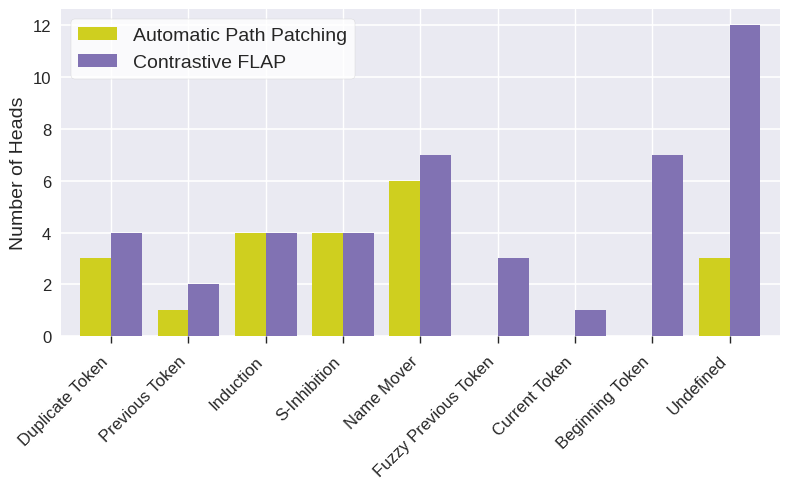

In [ ]:
from matplotlib.ticker import MaxNLocator
import seaborn as sns

title_font=16
fontsize=14
labelsize =12

order = [
    "Duplicate Token", 
    "Previous Token", 
    "Induction", 
    "S-Inhibition",  
    "Name Mover",
    "Fuzzy Previous Token",
    "Current Token",
    "Beginning Token",
    "Undefined"
]

subtractedFLAP = {
    "Duplicate Token": 4, 
    "Previous Token": 2, 
    "Induction": 4, 
    "S-Inhibition": 4,
    "Name Mover": 7,  
    "Fuzzy Previous Token": 3, 
    "Current Token": 1, 
    "Beginning Token": 7, 
    "Undefined": 12
}

all_labels = set(path_patching.keys()) | set(vanillaFLAP.keys())#| set(subtractedFLAP.keys())
df = pd.DataFrame({
    "Label": list(all_labels),
    "Automatic Path Patching": [path_patching.get(label, 0) for label in all_labels],
    #"Vanilla FLAP": [vanillaFLAP.get(label, 0) for label in all_labels], 
    "Contrastive FLAP": [subtractedFLAP.get(label, 0) for label in all_labels]

})

# Reindex dataframe
df["Label"] = pd.Categorical(df["Label"], categories=order, ordered=True)
df_long = df.melt(id_vars="Label", var_name="Method", value_name="Value")

circuit_analysis_barplot(df, order)

# Precision and Recall

In [27]:
from circuits_contr_APP import choose_contr_APP_circuit
from utils.eval_circuit import performance_achieved, circuit_size, get_intersection_num, precision, TPR, get_union_num, merge_circuits
from circuits_PP import choose_circuit
from circuits_FLAP import choose_contrastive_FLAP_circuit, choose_vanilla_FLAP_circuit, choose_hybrid_FLAP_circuit
from circuits_APP import choose_APP_circuit

#model_name="Qwen/Qwen2.5-0.5B"
#model_name="Qwen/Qwen2.5-7B"
model_name="gpt2-large"
#model_name="gpt2"

all_tasks=["ioi", "GreaterThan", "GenderedPronouns", "induction", "Docstring"]
#all_tasks=["Docstring"]


## APP

In [28]:
eval_tokenizer = load_tokenizer(model_name)
model_hooked = load_hooked_transformer(model_name, device=device, cache_dir=cache_dir)

for t in all_tasks:
    print("\n \n" , "#" * 50, "\n")

    PP_CIRCUIT = choose_circuit(t, model_name)
    APP_CIRCUIT = choose_APP_circuit(t, model_name)
    #APP_CIRCUIT = choose_contr_APP_circuit(t, model_name)
    circuit_name = get_circuit_name(t)
    
    eval_dataset = load_dataset(
        prepend_bos=False,
        task=t, 
        patching_method="path",
        tokenizer=eval_tokenizer, 
        N=N, 
        device=device,
        model_name=model_name,
        seed=seed
        )
    
    with torch.no_grad():
        logits_gt = model_hooked(eval_dataset.clean_tokens)
        
    ave_logit_gt = ave_logit_diff(
        logits=logits_gt, 
        correct_answers=eval_dataset.correct_answers, 
        wrong_answers=eval_dataset.wrong_answers,
        target_idx=eval_dataset.target_idx.to(device), 
        task=t,
        model_name=model_name
        )
    
    print("Average logit difference original model: ", ave_logit_gt)
    
    ave_logit, performance = batch_evaluate_circiut(
        model = model_hooked, 
        CIRCUIT=PP_CIRCUIT,
        dataset=eval_dataset,
        ave_logit_gt=ave_logit_gt,
        task=t,
        model_name=model_name, 
        epochs = epochs, 
        batch_size = batch_size 
    )
    
    performance_man = performance_achieved(ave_logit_gt, ave_logit)
    circuit_size_man = circuit_size(PP_CIRCUIT)

    print("*" * 50)
    print("PP Circuit for ", t, "task:")
    print("performance", performance_man)
    print("size", circuit_size_man)
    
    ave_logit, performance = batch_evaluate_circiut(
        model = model_hooked, 
        CIRCUIT=APP_CIRCUIT,
        dataset=eval_dataset,
        ave_logit_gt=ave_logit_gt,
        task=t,
        model_name=model_name, 
        epochs = epochs, 
        batch_size = batch_size 
    )
    
    performance_aut = performance_achieved(ave_logit_gt, ave_logit)
    circuit_size_aut = circuit_size(APP_CIRCUIT)
    print("*" * 50)
    print("APP Circuit for ", t, "task:")
    print("performance", performance_aut)
    print("size", circuit_size_aut)
    
    recall = TPR(APP_CIRCUIT, PP_CIRCUIT)
    prec = precision(APP_CIRCUIT, PP_CIRCUIT)
    IoU = get_intersection_num(APP_CIRCUIT, PP_CIRCUIT) / get_union_num(APP_CIRCUIT, PP_CIRCUIT)
    
    print("*" * 50)
    print("precision", prec)
    print("recall", recall)
    print("IoU", IoU )
    


load gpt2 tokenizer
loading gpt2-large as HookedTransformer
use float 16
Loaded pretrained model gpt2-large into HookedTransformer
Moving model to device:  cuda

 
 ################################################## 

path /mnt/lustre/work/eickhoff/esx670/res_final/gpt2-large/ioi/path/automatic/logits_diff/sqrt/min_threshold-0.002/k_2-scale_1.5/
path /mnt/lustre/work/eickhoff/esx670/res_final
using gpt2-large model in IOI dataset
Average logit difference original model:  4.0390625
**************************************************
PP Circuit for  ioi task:
performance 81.81818181818181
size 193
**************************************************
APP Circuit for  ioi task:
performance 67.11798839458413
size 185
**************************************************
precision 0.5621621621621622
recall 0.538860103626943
IoU 0.3795620437956204

 
 ################################################## 

path /mnt/lustre/work/eickhoff/esx670/res_final/gpt2-large/GreaterThan/path/automatic/logits_dif

## Subtracted FLAP

In [ ]:
eval_tokenizer = load_tokenizer(model_name)
model_hooked = load_hooked_transformer(model_name, device=device, cache_dir=cache_dir)

for t in all_tasks:
    print("\n \n" , "#" * 50, "\n")

    PP_CIRCUIT = choose_circuit(t, model_name)
    CONTR_CIRCUIT = choose_contr_FLAP_circuit(t, model_name)
    circuit_name = get_circuit_name(t)
    
    eval_dataset = load_dataset(
        prepend_bos=False,
        task=t, 
        patching_method="path",
        tokenizer=eval_tokenizer, 
        N=N, 
        device=device,
        model_name=model_name,
        seed=seed
        )
    
    with torch.no_grad():
        logits_gt = model_hooked(eval_dataset.clean_tokens)
        
    ave_logit_gt = ave_logit_diff(
        logits=logits_gt, 
        correct_answers=eval_dataset.correct_answers, 
        wrong_answers=eval_dataset.wrong_answers,
        target_idx=eval_dataset.target_idx.to(device), 
        task=t,
        model_name=model_name
        )
    
    print("Average logit difference original model: ", ave_logit_gt)
    
    ave_logit, performance = batch_evaluate_circiut(
        model = model_hooked, 
        CIRCUIT=PP_CIRCUIT,
        dataset=eval_dataset,
        ave_logit_gt=ave_logit_gt,
        task=t,
        model_name=model_name, 
        epochs = epochs, 
        batch_size = batch_size 
    )
    
    performance_man = performance_achieved(ave_logit_gt, ave_logit)
    circuit_size_man = circuit_size(PP_CIRCUIT)

    print("*" * 50)
    print("PP Circuit for ", t, "task:")
    print("performance", performance_man)
    print("size", circuit_size_man)
    
    ave_logit, performance = batch_evaluate_circiut(
        model = model_hooked, 
        CIRCUIT=CONTR_CIRCUIT,
        dataset=eval_dataset,
        ave_logit_gt=ave_logit_gt,
        task=t,
        model_name=model_name, 
        epochs = epochs, 
        batch_size = batch_size 
    )
    
    performance_aut = performance_achieved(ave_logit_gt, ave_logit)
    circuit_size_aut = circuit_size(CONTR_CIRCUIT)
    print("*" * 50)
    print("FLAP Circuit for ", t, "task:")
    print("performance", performance_aut)
    print("size", circuit_size_aut)
    
    recall = TPR(CONTR_CIRCUIT, PP_CIRCUIT)
    prec = precision(CONTR_CIRCUIT, PP_CIRCUIT)
    IoU = get_intersection_num(CONTR_CIRCUIT, PP_CIRCUIT) / get_union_num(CONTR_CIRCUIT, PP_CIRCUIT)
    
    print("*" * 50)
    print("precision", prec)
    print("recall", recall)
    print("IoU", IoU )
    



load gpt2 tokenizer
loading gpt2-large as HookedTransformer
use float 16
Loaded pretrained model gpt2-large into HookedTransformer
Moving model to device:  cuda

 
 ################################################## 

path /mnt/lustre/work/eickhoff/esx670/res_final/gpt2-large/ioi/path/automatic/logits_diff/sqrt/min_threshold-0.002/k_2-scale_1.5/
using gpt2-large model in IOI dataset
Average logit difference original model:  4.0390625
**************************************************
PP Circuit for  ioi task:
performance 81.81818181818181
size 193
**************************************************
FLAP Circuit for  ioi task:
performance 70.45454545454545
size 186
**************************************************
precision 0.5645161290322581
recall 0.5440414507772021
IoU 0.38321167883211676

 
 ################################################## 

path /mnt/lustre/work/eickhoff/esx670/res_final/gpt2-large/GreaterThan/path/automatic/logits_diff/sqrt/min_threshold-0.002/k_2-scale_2.5
Load

## Hybrid FLAP

In [275]:
eval_tokenizer = load_tokenizer(model_name)
model_hooked = load_hooked_transformer(model_name, device=device, cache_dir=cache_dir)

for t in all_tasks:
    print("\n \n" , "#" * 50, "\n")

    PP_CIRCUIT = choose_circuit(t, model_name)
    HYBRID_CIRCUIT = choose_hybrid_FLAP_circuit(t, model_name)
    circuit_name = get_circuit_name(t)
    
    eval_dataset = load_dataset(
        prepend_bos=False,
        task=t, 
        patching_method="path",
        tokenizer=eval_tokenizer, 
        N=N, 
        device=device,
        model_name=model_name,
        seed=seed
        )
    
    with torch.no_grad():
        logits_gt = model_hooked(eval_dataset.clean_tokens)
        
    ave_logit_gt = ave_logit_diff(
        logits=logits_gt, 
        correct_answers=eval_dataset.correct_answers, 
        wrong_answers=eval_dataset.wrong_answers,
        target_idx=eval_dataset.target_idx.to(device), 
        task=t,
        model_name=model_name
        )
    
    print("Average logit difference original model: ", ave_logit_gt)
    
    ave_logit, performance = batch_evaluate_circiut(
        model = model_hooked, 
        CIRCUIT=PP_CIRCUIT,
        dataset=eval_dataset,
        ave_logit_gt=ave_logit_gt,
        task=t,
        model_name=model_name, 
        epochs = epochs, 
        batch_size = batch_size 
    )
    
    performance_man = performance_achieved(ave_logit_gt, ave_logit)
    circuit_size_man = circuit_size(PP_CIRCUIT)

    print("*" * 50)
    print("PP Circuit for ", t, "task:")
    print("performance", performance_man)
    print("size", circuit_size_man)
    
    ave_logit, performance = batch_evaluate_circiut(
        model = model_hooked, 
        CIRCUIT=HYBRID_CIRCUIT,
        dataset=eval_dataset,
        ave_logit_gt=ave_logit_gt,
        task=t,
        model_name=model_name, 
        epochs = epochs, 
        batch_size = batch_size 
    )
    
    performance_aut = performance_achieved(ave_logit_gt, ave_logit)
    circuit_size_aut = circuit_size(HYBRID_CIRCUIT)
    print("*" * 50)
    print("HYBRID_CIRCUIT Circuit for ", t, "task:")
    print("performance", performance_aut)
    print("size", circuit_size_aut)
    
    recall = TPR(HYBRID_CIRCUIT, PP_CIRCUIT)
    prec = precision(HYBRID_CIRCUIT, PP_CIRCUIT)
    IoU = get_intersection_num(HYBRID_CIRCUIT, PP_CIRCUIT) / get_union_num(HYBRID_CIRCUIT, PP_CIRCUIT)
    
    print("*" * 50)
    print("precision", prec)
    print("recall", recall)
    print("IoU", IoU )
    



load gpt2 tokenizer
loading gpt2 as HookedTransformer
use float 16
Loaded pretrained model gpt2 into HookedTransformer
Moving model to device:  cuda

 
 ################################################## 

path /mnt/lustre/work/eickhoff/esx670/res_final/gpt2/ioi/path/automatic/logits_diff/sqrt/min_threshold-0.01/k_2-scale_2.5/
using gpt2 model in IOI dataset
Average logit difference original model:  3.0078125
**************************************************
PP Circuit for  ioi task:
performance 84.6103896103896
size 21
**************************************************
HYBRID_CIRCUIT Circuit for  ioi task:
performance 89.35064935064935
size 52
**************************************************
precision 0.36538461538461536
recall 0.9047619047619048
IoU 0.35185185185185186

 
 ################################################## 

path /mnt/lustre/work/eickhoff/esx670/res_final/gpt2/GreaterThan/path/automatic/logits_diff/sqrt/min_threshold-0.02/k_2-scale_2/
Load GreaterThan with gpt2
Av

In [277]:
from circuits_PP import choose_circuit
PP_CIRCUIT = choose_circuit("ioi", "gpt2")
PP_CIRCUIT

path /mnt/lustre/work/eickhoff/esx670/res_final/gpt2/ioi/path/automatic/logits_diff/sqrt/min_threshold-0.01/k_2-scale_2.5/


{0: [10, 1],
 3: [0],
 4: [11, 3],
 5: [5, 8, 9],
 6: [9, 0],
 7: [9, 3, 1],
 8: [6, 10],
 9: [6, 9, 7],
 10: [0, 7],
 11: [10]}